
# Metaheuristics - lecture XYZ

## Objectives
* Getting familiar with different classes of optimization problems

## Continuous optimization problems

Local optimization:  for a function $f:D\to R$, $D=[a_1,b_1]\times [a_2,b_2]\times \ldots \times [a_n,b_n]$, find $x^*\in D$,  such that $f(x^*)\leq f(x)$ for all $x\in D$

Test functions
* Sphere function (uni-modal, convex function) $f:R^n\rightarrow R$, $f(x^1,\ldots, x^n)=\sum_{i=1}^n (x^i)^2$ (unique optimum)

* Griewank function (uni-modal, non-convex function) $f:R^n\rightarrow R$, $f(x^1\ldots, x^n)= 1 + \sum_{i=1}^{n} (x^i)^2/4000 - \prod_{i=1}^{n} \cos(x^i)/\sqrt(i)$ 

* Rastrigin function (multi-modal) $f:R^n\rightarrow R$, $f(x^1\ldots, x^n)=10 n + \sum_{i=1}^{n} ((x^i)^2 - 10 \cos(2\pi x^i))$


More details: https://www.sfu.ca/~ssurjano/optimization.html


## Problem statement
Implement a GA for function optimisation: identify the optimal point of f(x). 



**Function ladscape**

Define the function and plot it in order to observe its shape/aspect and optimal points

In [22]:
def fcEval(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    degrees = param['degrees']
    noEdges = param['noEdges']  
    M = 2 * noEdges
    Q = 0.0
    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if (communities[i] == communities[j]):
               Q += (mat[i][j] - degrees[i] * degrees[j] / M)
    return Q * 1 / M

In [23]:
# read the network details
def readNet(fileName):
    f = open(fileName, "r")
    net = {}
    n = int(f.readline())
    net['noNodes'] = n
    mat = []
    for i in range(n):
        mat.append([])
        line = f.readline()
        elems = line.split(" ")
        for j in range(n):
            mat[-1].append(int(elems[j]))
    net["mat"] = mat 
    degrees = []
    noEdges = 0
    for i in range(n):
        d = 0
        for j in range(n):
            if (mat[i][j] == 1):
                d += 1
            if (j > i):
                noEdges += mat[i][j]
        degrees.append(d)
    net["noEdges"] = noEdges
    net["degrees"] = degrees
    f.close()
    return net

def readGMLFile(fileName):
    f = open(fileName, "r")
    net = {}
    creator_name = f.readline();
    n = 0
    m = 0
    mat = []
    f.readline()  # graph
    f.readline()  # [
    f.readline()  # directed 0
    line = f.readline();
    while line != ']':
        line = line.replace("\n", "")
        line = line.strip()
        if line == 'node':
            # adding node
            f.readline()  # [
            id_line = f.readline()  # id number
            id = int(id_line.split()[1])
            label_line = f.readline()  # label string
            #label = label_line.split()[1]
            f.readline()
            f.readline()  # ]
            n = n + 1
        elif line == 'edge':
            if m == 0:
                for i in range(n):
                    mat.append([])
                    for j in range(n):
                        mat[i].append(0)
            # adding edge
            f.readline()  # [
            source_line = f.readline()  # source number
            source = int(source_line.split()[1])
            source = source - 1
            target_line = f.readline()  # target number
            target = int(target_line.split()[1])
            target = target - 1
            f.readline()  # ]
            mat[source][target] = 1
            mat[target][source] = 1
            m = m + 1
        line = f.readline()
        line = line.strip()
        line = line.replace("\n", "")
    degrees = []
    for i in range(n):
        d = 0
        for j in range(n):
            if mat[i][j] == 1:
                d += 1
        degrees.append(d)
    net['noNodes'] = n
    net['noEdges'] = m
    net['degrees'] = degrees
    net['mat'] = mat
    return net

**GA running**

Use the GA (with real encoding) for identify the optimal solution


In [24]:


from random import randint

class GA:
    def __init__(self, param = None, problParam = None):
        self.__param = param
        self.__problParam = problParam
        self.__population = []
        
    @property
    def population(self):
        return self.__population
    
    def initialisation(self):
        for _ in range(0, self.__param['popSize']):
            c = Chromosome(self.__problParam)
            self.__population.append(c)
    
    def evaluation(self):
        for c in self.__population:
            c.fitness = self.__problParam['function'](c.repres, network)
            
    def bestChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness > best.fitness):
                best = c
        return best
        
    def worstChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness < best.fitness):
                best = c
        return best

    def selection(self):
        pos1 = randint(0, self.__param['popSize'] - 1)
        pos2 = randint(0, self.__param['popSize'] - 1)
        if (self.__population[pos1].fitness > self.__population[pos2].fitness):
            return pos1
        else:
            return pos2 
        
    
    def oneGeneration(self):
        newPop = []
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.binomial_crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationElitism(self):
        newPop = [self.bestChromosome()]
        for _ in range(self.__param['popSize'] - 1):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()
        
    def oneGenerationSteadyState(self):
        newPop = [self.bestChromosome()]
        for _ in range(self.__param['popSize'] - 1):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.binomial_crossover(p2)
            off.mutation()
            off.fitness = self.__problParam['function'](off.repres, network)
            worst = self.worstChromosome()
            if off.fitness < worst.fitness:
                off = worst
            newPop.append(off)
        self.__population = newPop
        self.evaluation()


In [25]:
from RealChromosome import Chromosome
#from BinChromosome import Chromosome
from random import seed 
import os

#generate seed
seed()

#read net
crtDir =  os.getcwd()
filePath = os.path.join(crtDir, 'data', 'football.gml')
network = readGMLFile(filePath)
# initialise de GA parameters
gaParam = {'popSize' : 100, 'noGen' : 100, 'pc' : 0.8, 'pm' : 0.1}
# problem parameters
problParam = {'cr' : 0.5, 'min' : 1, 'max' : 7 if 7 < round(network['noNodes'] / 3) else round(network['noNodes'] / 3), 'function' : fcEval, 'noDim' : network['noNodes'], 'noBits' : 8}

# store the best/average solution of each iteration (for a final plot used to anlyse the GA's convergence)
bestRepres = []
bestFitness = -999999

ga = GA(gaParam, problParam)
ga.initialisation()
ga.evaluation()
    
for g in range(gaParam['noGen']):
    #plotting preparation
    bestSolX = ga.bestChromosome().repres
    bestSolY = ga.bestChromosome().fitness
    if bestSolY > bestFitness :
        bestFitness = bestSolY
        bestRepres.clear()
        for elem in bestSolX:
            bestRepres.append(elem)
    
    #logic alg
    ga.oneGenerationSteadyState()
    # ga.oneGenerationElitism()
    # ga.oneGenerationSteadyState()
    
    bestChromo = ga.bestChromosome()
    print('Best solution in generation ' + str(g) + ' is: x = ' + str(bestChromo.repres) + ' f(x) = ' + str(bestChromo.fitness)) 

print('\n\nBest solution is x = ' + str(bestRepres) + ' f(x) = ' + str(bestFitness))
number_of_groups = 0
groups = {}
for el in bestRepres:
    if groups.get(el) is None :
        groups[el] = 1
        number_of_groups += 1
        
print('The number of groups is : ' + str(number_of_groups) + ' and the associations to groups are (Node : Group):')
for i in range(len(bestRepres)):
    print(str(i) + ' : ' + str(bestRepres[i]))
        

Best solution in generation 0 is: x = [1, 4, 6, 5, 4, 7, 1, 5, 5, 1, 6, 3, 4, 2, 7, 5, 3, 2, 4, 5, 7, 2, 6, 7, 7, 6, 5, 2, 7, 4, 6, 3, 1, 6, 1, 1, 2, 1, 4, 7, 6, 5, 6, 3, 1, 5, 6, 1, 3, 1, 7, 4, 7, 7, 4, 1, 3, 2, 2, 2, 6, 3, 3, 1, 6, 3, 5, 7, 2, 4, 4, 5, 6, 1, 3, 2, 7, 7, 4, 6, 4, 6, 4, 5, 4, 3, 5, 6, 7, 7, 6, 3, 5, 5, 1, 3, 5, 4, 3, 3, 3, 6, 2, 2, 1, 2, 5, 2, 1, 7, 7, 3, 2, 7, 4] f(x) = 0.042892983639736926
Best solution in generation 1 is: x = [1, 4, 6, 5, 4, 7, 1, 5, 5, 1, 6, 3, 4, 2, 7, 5, 3, 2, 4, 5, 7, 2, 6, 7, 7, 6, 5, 2, 7, 4, 6, 3, 1, 6, 1, 1, 2, 1, 4, 7, 6, 5, 6, 3, 1, 5, 6, 1, 3, 1, 7, 4, 7, 7, 4, 1, 3, 2, 2, 2, 6, 3, 3, 1, 6, 3, 5, 7, 2, 4, 4, 5, 6, 1, 3, 2, 7, 7, 4, 6, 4, 6, 4, 5, 4, 3, 5, 6, 7, 7, 6, 3, 5, 5, 1, 3, 5, 4, 3, 3, 3, 6, 2, 2, 1, 2, 5, 2, 1, 7, 7, 3, 2, 7, 4] f(x) = 0.042892983639736926
Best solution in generation 2 is: x = [6, 7, 7, 6, 2, 1, 3, 3, 2, 6, 5, 6, 3, 5, 2, 2, 6, 5, 1, 6, 6, 4, 3, 7, 1, 7, 1, 5, 6, 6, 2, 7, 2, 7, 2, 1, 7, 5, 1, 1, 1, 4, 1, 7, 3, 4,

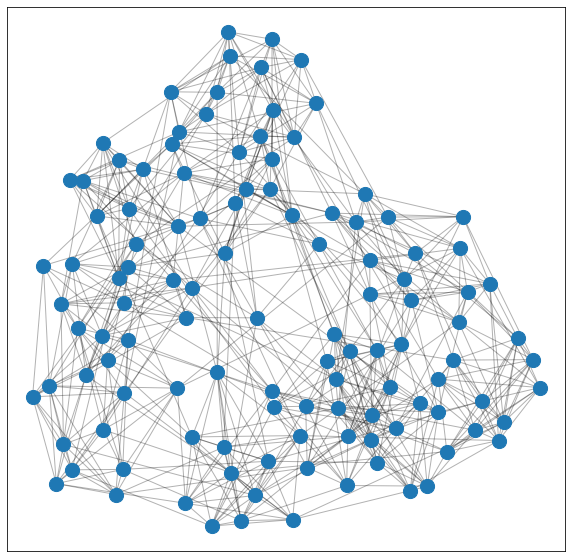

In [26]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import warnings 

warnings.simplefilter('ignore')

A=np.matrix(network["mat"])
G=nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(10, 10))  # image is 8 x 8 inches 
nx.draw_networkx_nodes(G, pos, node_size=200, cmap=plt.cm.RdYlBu)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)


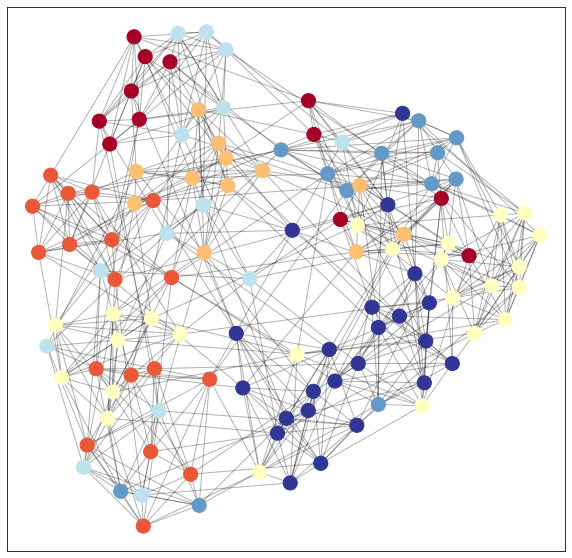

In [27]:
# plot a particular division in communities

A=np.matrix(network["mat"])
G=nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(10, 10))  # image is 8 x 8 inches 
nx.draw_networkx_nodes(G, pos, node_size = 200, cmap = plt.cm.RdYlBu, node_color = bestRepres)
nx.draw_networkx_edges(G, pos, alpha = 0.3)
plt.show(G)